# 1a

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import numpy as np
import seaborn as sns

X_train: (60000, 32, 32)
Y_train: (60000,)
X_test:  (10000, 32, 32)
Y_test:  (10000,)


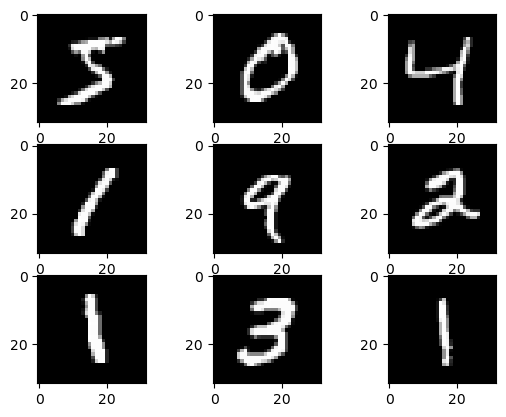

In [2]:
(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
 
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for i in range(9):  
    plt.subplot(3,3,i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
nml_train_X = np.array([scaler.fit_transform(img) for img in train_X])
nml_test_X = np.array([scaler.fit_transform(img) for img in test_X])

In [4]:
nml_train_X.shape

(60000, 32, 32)

In [5]:
nml_test_X.shape

(10000, 32, 32)

## 1b:

In [6]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [7]:
from torch.optim import SGD, Adam
import torch
from torch import nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x.reshape(x.shape[0], -1)):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_inputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        # Conversion of input arrays to correct shape
        train_input = self.input_transform(inputs)
        val_inputs = self.input_transform(val_inputs)
        
        # Conversion of arrays to tensors
        inputs = torch.tensor(train_input, dtype= torch.float)
        outputs = torch.tensor(outputs, dtype = torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    # Square and sum each entry in each of the arrays and then sum all outputs from all arrays
                    loss = loss + 1e-5 * sum([(wei ** 2).sum() for wei in self.model.parameters()])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                acc = sum(torch.argmax(batch_predictions, dim = 1) == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies,
               "model": self.model}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        tensor_inp = torch.tensor(inputs, dtype = torch.float)
        tensor_out = torch.tensor(outputs, dtype = torch.int64)
        
        preds = self.model(tensor_inp)
        losses = nn.CrossEntropyLoss()(preds, tensor_out)
        losses = losses.item()
        acc = (sum(torch.argmax(preds, axis= 1) == tensor_out) / len(tensor_out)).item()
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [8]:
temp = lambda x: x.reshape(x.shape[0], -1)

In [9]:
# Function for printing out final losses and accuracies; plotting graphs
def dat_col_plot(mlp_dict, x_test):
    train_loss = mlp_dict['losses']
    val_loss = mlp_dict['val_losses']
    ovr_loss = np.array([train_loss, val_loss]).T
    print('Final Train Accuracy: ', mlp_dict['accuracies'][-1])
    print('Final Validation Accuracy: ', mlp_dict['val_accuracies'][-1])
    reshaped_test_x = torch.tensor(temp(x_test), dtype = torch.float)
    test_pred = mlp_dict['model'](reshaped_test_x)
    num_correct = sum(torch.argmax(test_pred, axis = 1) == torch.tensor(test_y, dtype = torch.int64))
    print('Test Accuracy: ', (num_correct / len(test_y)).item())
    print('Final Train Loss: ', mlp_dict['losses'][-1])
    print('Final Validation Loss: ', mlp_dict['val_losses'][-1] )
    plt.figure(figsize = (7,7))
    sns.lineplot(data = ovr_loss)
    plt.legend(title='Loss', loc='upper right', labels=['Train Loss', 'Val Loss'])
    plt.ylabel('Loss');
    plt.xlabel('Epochs')
    plt.title('Train & Validation Loss Over Epochs');

In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3, shuffle = True)
def cross_valid(train_input, train_labels, X_test, l2_ind = False):
    for train_ind, test_ind in kfold.split(train_input, train_labels):
        ann = ArtNN()
        mlp_trainer = Trainer(ann, "adam", 2e-3, 50, 128)
        trainfold_X = train_input[train_ind]
        trainfold_y = train_labels[train_ind]
        testfold_x = train_input[test_ind]
        testfold_y = train_labels[test_ind]
        train_val_dict = mlp_trainer.train(trainfold_X, trainfold_y, 
                   val_inputs= testfold_x, val_outputs= testfold_y, early_stop = True, l2=l2_ind)
        dat_col_plot(train_val_dict, X_test)
    return train_val_dict['model']

In [11]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.lys = nn.ModuleList([nn.Linear(1024, 3),
                                  nn.Linear(3,10),])
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.lys[0](x)
        x = self.activation(x)
        x = self.lys[1](x)
        return x

## 1c:

  2%|▉                                           | 1/50 [00:01<00:53,  1.10s/it]

Epoch 1/50 - Loss: 1.959 - Acc: 0.371
              Val_loss: 1.705 - Val_acc: 0.552


 22%|█████████▍                                 | 11/50 [00:09<00:31,  1.24it/s]

Epoch 11/50 - Loss: 0.797 - Acc: 0.726
              Val_loss: 0.804 - Val_acc: 0.727


 42%|██████████████████                         | 21/50 [00:17<00:23,  1.22it/s]

Epoch 21/50 - Loss: 0.706 - Acc: 0.762
              Val_loss: 0.728 - Val_acc: 0.757


 62%|██████████████████████████▋                | 31/50 [00:28<00:17,  1.06it/s]

Epoch 31/50 - Loss: 0.663 - Acc: 0.783
              Val_loss: 0.694 - Val_acc: 0.773


 82%|███████████████████████████████████▎       | 41/50 [00:37<00:08,  1.12it/s]

Epoch 41/50 - Loss: 0.644 - Acc: 0.790
              Val_loss: 0.681 - Val_acc: 0.778


func:'train'  took: 45.8120 sec
Final Train Accuracy:  0.7936000000000003
Final Validation Accuracy:  0.7788000106811523
Test Accuracy:  0.7864999771118164
Final Train Loss:  0.6347285076618197
Final Validation Loss:  0.6774760484695435


  2%|▉                                           | 1/50 [00:00<00:38,  1.29it/s]

Epoch 1/50 - Loss: 1.957 - Acc: 0.445
              Val_loss: 1.708 - Val_acc: 0.626


 22%|█████████▍                                 | 11/50 [00:09<00:31,  1.22it/s]

Epoch 11/50 - Loss: 0.889 - Acc: 0.694
              Val_loss: 0.888 - Val_acc: 0.692


 42%|██████████████████                         | 21/50 [00:17<00:24,  1.21it/s]

Epoch 21/50 - Loss: 0.826 - Acc: 0.718
              Val_loss: 0.840 - Val_acc: 0.716


 62%|██████████████████████████▋                | 31/50 [00:25<00:16,  1.14it/s]

Epoch 31/50 - Loss: 0.799 - Acc: 0.734
              Val_loss: 0.816 - Val_acc: 0.731


 82%|███████████████████████████████████▎       | 41/50 [00:34<00:07,  1.21it/s]

Epoch 41/50 - Loss: 0.778 - Acc: 0.747
              Val_loss: 0.806 - Val_acc: 0.741


func:'train'  took: 42.6676 sec
Final Train Accuracy:  0.7541000000000003
Final Validation Accuracy:  0.7482500076293945
Test Accuracy:  0.7436000108718872
Final Train Loss:  0.7661834259986876
Final Validation Loss:  0.7957722544670105


  2%|▉                                           | 1/50 [00:00<00:48,  1.02it/s]

Epoch 1/50 - Loss: 2.028 - Acc: 0.295
              Val_loss: 1.794 - Val_acc: 0.397


 22%|█████████▍                                 | 11/50 [00:09<00:35,  1.10it/s]

Epoch 11/50 - Loss: 0.909 - Acc: 0.649
              Val_loss: 0.933 - Val_acc: 0.630


 42%|██████████████████                         | 21/50 [00:18<00:24,  1.20it/s]

Epoch 21/50 - Loss: 0.809 - Acc: 0.711
              Val_loss: 0.854 - Val_acc: 0.699


 62%|██████████████████████████▋                | 31/50 [00:27<00:16,  1.14it/s]

Epoch 31/50 - Loss: 0.757 - Acc: 0.746
              Val_loss: 0.811 - Val_acc: 0.731


 82%|███████████████████████████████████▎       | 41/50 [00:38<00:10,  1.14s/it]

Epoch 41/50 - Loss: 0.723 - Acc: 0.762
              Val_loss: 0.784 - Val_acc: 0.746


func:'train'  took: 47.2477 sec
Final Train Accuracy:  0.7687249999999998
Final Validation Accuracy:  0.7505000233650208
Test Accuracy:  0.7638000249862671
Final Train Loss:  0.7039079693794249
Final Validation Loss:  0.7651873230934143


ArtNN(
  (lys): ModuleList(
    (0): Linear(in_features=1024, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=10, bias=True)
  )
  (activation): Sigmoid()
)

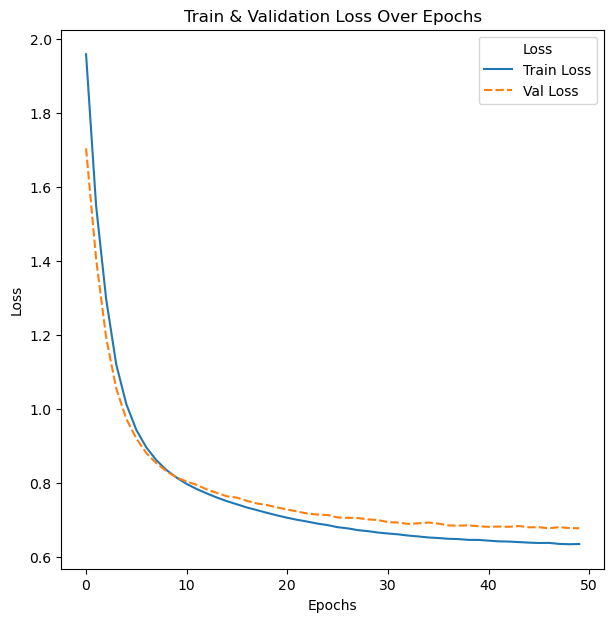

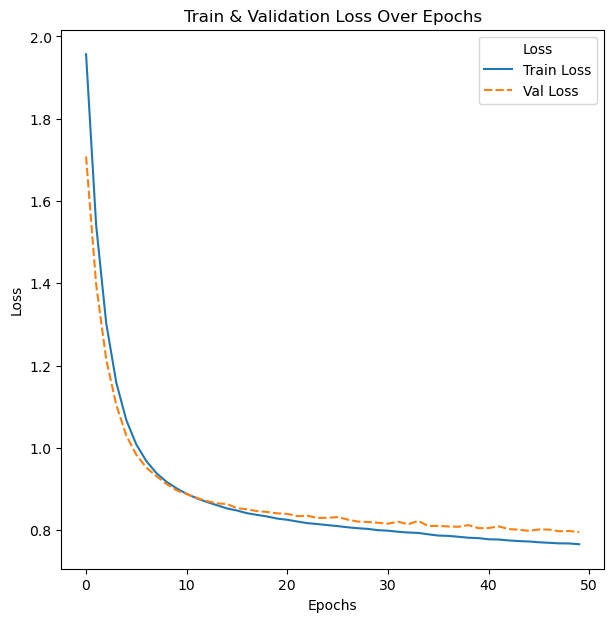

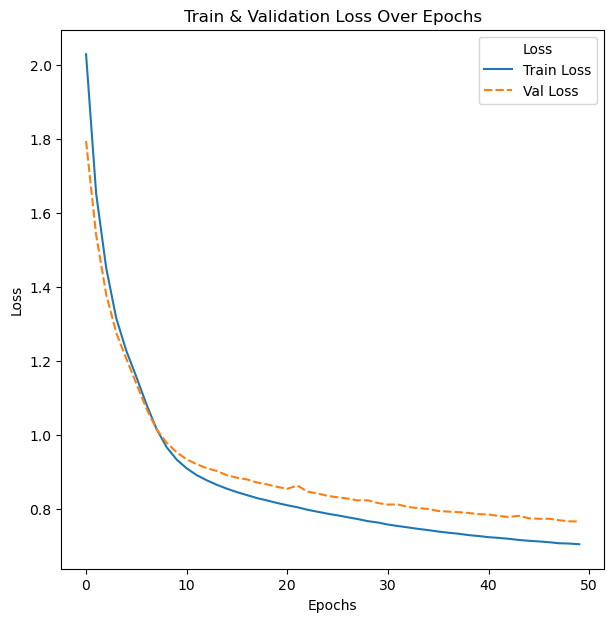

In [12]:
cross_valid(nml_train_X, train_y,nml_test_X)

It looks like the model is underfitting since although the validation and train error are closely tied to each other, the overall loss appears to plateau around 0.8, which is still higher than my ideal or accepted error of 0.3. It is important to note that as the epochs increase, the validation and train error start to diverge. 

## 1d: 50 neuron hidden layer

In [13]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.lys = nn.ModuleList([nn.Linear(1024, 50),
                                  nn.Linear(50,10),])
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.lys[0](x)
        x = self.activation(x)
        x = self.lys[1](x)
        return x

  2%|▉                                           | 1/50 [00:01<01:08,  1.41s/it]

Epoch 1/50 - Loss: 0.784 - Acc: 0.832
              Val_loss: 0.368 - Val_acc: 0.902


 22%|█████████▍                                 | 11/50 [00:15<00:55,  1.42s/it]

Epoch 11/50 - Loss: 0.093 - Acc: 0.974
              Val_loss: 0.148 - Val_acc: 0.956


 42%|██████████████████                         | 21/50 [00:28<00:36,  1.26s/it]

Epoch 21/50 - Loss: 0.042 - Acc: 0.991
              Val_loss: 0.132 - Val_acc: 0.961


 62%|██████████████████████████▋                | 31/50 [00:41<00:23,  1.26s/it]

Epoch 31/50 - Loss: 0.019 - Acc: 0.997
              Val_loss: 0.141 - Val_acc: 0.961


 82%|███████████████████████████████████▎       | 41/50 [00:54<00:11,  1.27s/it]

Epoch 41/50 - Loss: 0.008 - Acc: 1.000
              Val_loss: 0.150 - Val_acc: 0.962


func:'train'  took: 66.1522 sec
Final Train Accuracy:  0.999924999999996
Final Validation Accuracy:  0.9607999920845032
Test Accuracy:  0.9646999835968018
Final Train Loss:  0.003654112287983298
Final Validation Loss:  0.16449834406375885


  2%|▉                                           | 1/50 [00:01<01:00,  1.23s/it]

Epoch 1/50 - Loss: 0.785 - Acc: 0.828
              Val_loss: 0.357 - Val_acc: 0.908


 22%|█████████▍                                 | 11/50 [00:13<00:47,  1.21s/it]

Epoch 11/50 - Loss: 0.093 - Acc: 0.975
              Val_loss: 0.136 - Val_acc: 0.959


 42%|██████████████████                         | 21/50 [00:25<00:35,  1.21s/it]

Epoch 21/50 - Loss: 0.043 - Acc: 0.990
              Val_loss: 0.122 - Val_acc: 0.964


 62%|██████████████████████████▋                | 31/50 [00:40<00:27,  1.46s/it]

Epoch 31/50 - Loss: 0.020 - Acc: 0.997
              Val_loss: 0.126 - Val_acc: 0.963


 82%|███████████████████████████████████▎       | 41/50 [00:53<00:12,  1.37s/it]

Epoch 41/50 - Loss: 0.009 - Acc: 0.999
              Val_loss: 0.138 - Val_acc: 0.962


func:'train'  took: 65.2717 sec
Final Train Accuracy:  0.999849999999996
Final Validation Accuracy:  0.9610999822616577
Test Accuracy:  0.9635000228881836
Final Train Loss:  0.004127538235113019
Final Validation Loss:  0.15232305228710175


  2%|▉                                           | 1/50 [00:01<01:11,  1.45s/it]

Epoch 1/50 - Loss: 0.785 - Acc: 0.829
              Val_loss: 0.351 - Val_acc: 0.911


 22%|█████████▍                                 | 11/50 [00:16<01:02,  1.61s/it]

Epoch 11/50 - Loss: 0.095 - Acc: 0.973
              Val_loss: 0.136 - Val_acc: 0.959


 42%|██████████████████                         | 21/50 [00:33<00:44,  1.53s/it]

Epoch 21/50 - Loss: 0.042 - Acc: 0.991
              Val_loss: 0.116 - Val_acc: 0.964


 62%|██████████████████████████▋                | 31/50 [00:47<00:25,  1.34s/it]

Epoch 31/50 - Loss: 0.019 - Acc: 0.997
              Val_loss: 0.122 - Val_acc: 0.966


 82%|███████████████████████████████████▎       | 41/50 [01:01<00:12,  1.33s/it]

Epoch 41/50 - Loss: 0.008 - Acc: 1.000
              Val_loss: 0.135 - Val_acc: 0.965


func:'train'  took: 72.5546 sec
Final Train Accuracy:  0.9999499999999958
Final Validation Accuracy:  0.9638000130653381
Test Accuracy:  0.9641000032424927
Final Train Loss:  0.0035191668493673176
Final Validation Loss:  0.14674808084964752


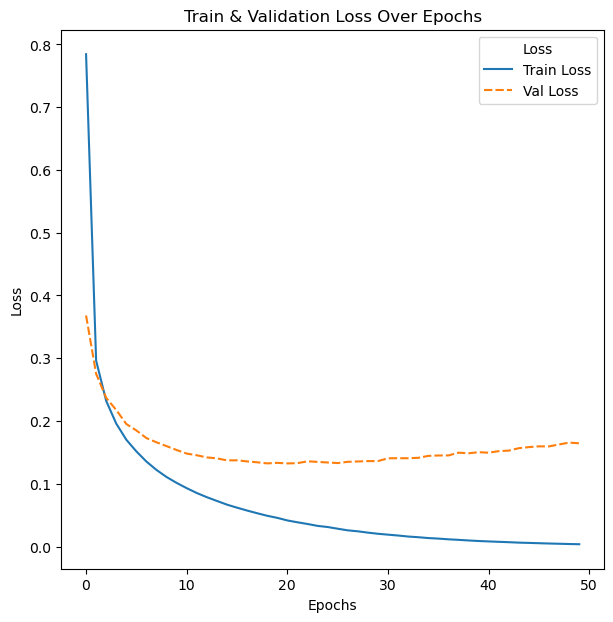

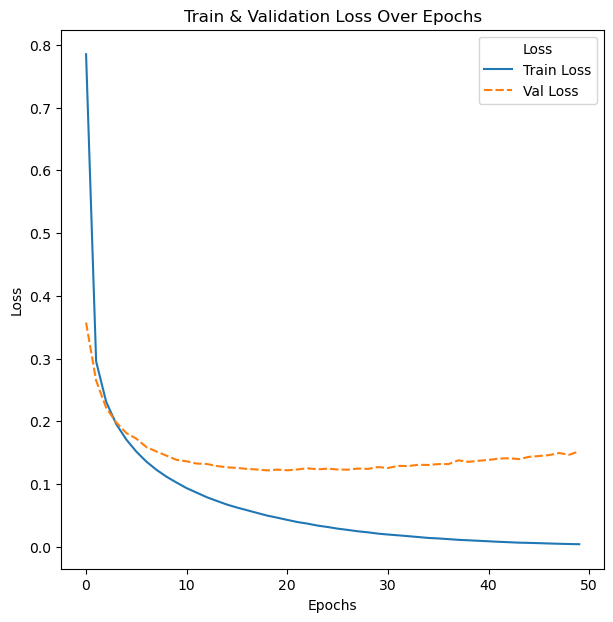

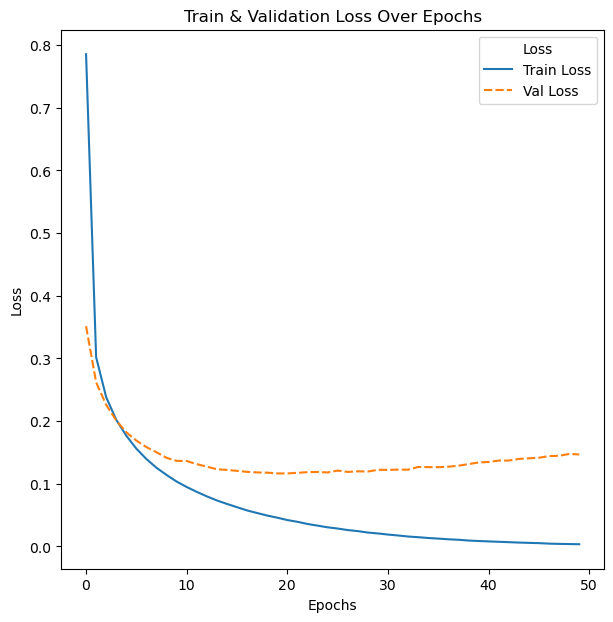

In [14]:
tuned_model = cross_valid(nml_train_X, train_y, nml_test_X)

It looks like there is overfitting occuring as the validation and train loss are diverging away from each other at around 3 or 4 epochs. This divergence grows for the remaining number of epochs. It is good to see with the increase in the number of neurons from 3 to 50 in the hidden layer, both the train and validation loss dropped by 0.8 compared to the model in 1c. More importantly, there is a massive increase in the test accuracy from around 78% to 96%. The divergence in train and validation loss and the really low train loss indicate more model tuning is needed to resolve overfitting issue. 

## 2a: With Dropout

In [15]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.lys = nn.ModuleList([nn.Linear(1024, 50),
                                  nn.Linear(50,10),])
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(p= 0.15)
    
    def forward(self, x):
        x = self.lys[0](x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.lys[1](x)
        return x

  2%|▉                                           | 1/50 [00:01<00:59,  1.22s/it]

Epoch 1/50 - Loss: 0.853 - Acc: 0.817
              Val_loss: 0.405 - Val_acc: 0.898


 22%|█████████▍                                 | 11/50 [00:13<00:46,  1.20s/it]

Epoch 11/50 - Loss: 0.139 - Acc: 0.959
              Val_loss: 0.195 - Val_acc: 0.942


 42%|██████████████████                         | 21/50 [00:25<00:35,  1.21s/it]

Epoch 21/50 - Loss: 0.094 - Acc: 0.972
              Val_loss: 0.189 - Val_acc: 0.943


 62%|██████████████████████████▋                | 31/50 [00:37<00:23,  1.22s/it]

Epoch 31/50 - Loss: 0.072 - Acc: 0.977
              Val_loss: 0.186 - Val_acc: 0.946


 82%|███████████████████████████████████▎       | 41/50 [00:49<00:10,  1.19s/it]

Epoch 41/50 - Loss: 0.060 - Acc: 0.981
              Val_loss: 0.188 - Val_acc: 0.947


func:'train'  took: 60.4473 sec
Final Train Accuracy:  0.9838250000000017
Final Validation Accuracy:  0.9467499852180481
Test Accuracy:  0.95169997215271
Final Train Loss:  0.05062003479003908
Final Validation Loss:  0.1972254365682602


  2%|▉                                           | 1/50 [00:01<00:53,  1.09s/it]

Epoch 1/50 - Loss: 0.841 - Acc: 0.817
              Val_loss: 0.394 - Val_acc: 0.904


 22%|█████████▍                                 | 11/50 [00:13<00:46,  1.19s/it]

Epoch 11/50 - Loss: 0.133 - Acc: 0.962
              Val_loss: 0.171 - Val_acc: 0.948


 42%|██████████████████                         | 21/50 [00:25<00:34,  1.20s/it]

Epoch 21/50 - Loss: 0.092 - Acc: 0.972
              Val_loss: 0.163 - Val_acc: 0.951


 62%|██████████████████████████▋                | 31/50 [00:37<00:23,  1.23s/it]

Epoch 31/50 - Loss: 0.072 - Acc: 0.978
              Val_loss: 0.164 - Val_acc: 0.951


 82%|███████████████████████████████████▎       | 41/50 [00:49<00:10,  1.20s/it]

Epoch 41/50 - Loss: 0.060 - Acc: 0.981
              Val_loss: 0.162 - Val_acc: 0.952


func:'train'  took: 60.2942 sec
Final Train Accuracy:  0.9830250000000009
Final Validation Accuracy:  0.9520999789237976
Test Accuracy:  0.949400007724762
Final Train Loss:  0.05041806206107141
Final Validation Loss:  0.168633371591568


  2%|▉                                           | 1/50 [00:01<00:55,  1.14s/it]

Epoch 1/50 - Loss: 0.848 - Acc: 0.825
              Val_loss: 0.398 - Val_acc: 0.899


 22%|█████████▍                                 | 11/50 [00:13<00:47,  1.22s/it]

Epoch 11/50 - Loss: 0.140 - Acc: 0.959
              Val_loss: 0.177 - Val_acc: 0.948


 42%|██████████████████                         | 21/50 [00:25<00:35,  1.23s/it]

Epoch 21/50 - Loss: 0.096 - Acc: 0.972
              Val_loss: 0.168 - Val_acc: 0.949


 62%|██████████████████████████▋                | 31/50 [00:39<00:25,  1.33s/it]

Epoch 31/50 - Loss: 0.074 - Acc: 0.977
              Val_loss: 0.159 - Val_acc: 0.954


 82%|███████████████████████████████████▎       | 41/50 [00:53<00:11,  1.26s/it]

Epoch 41/50 - Loss: 0.058 - Acc: 0.982
              Val_loss: 0.167 - Val_acc: 0.950


func:'train'  took: 64.8724 sec
Final Train Accuracy:  0.9842500000000017
Final Validation Accuracy:  0.9512500166893005
Test Accuracy:  0.9531000256538391
Final Train Loss:  0.05018854117691516
Final Validation Loss:  0.1743556559085846


ArtNN(
  (lys): ModuleList(
    (0): Linear(in_features=1024, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (activation): Sigmoid()
  (dropout): Dropout(p=0.15, inplace=False)
)

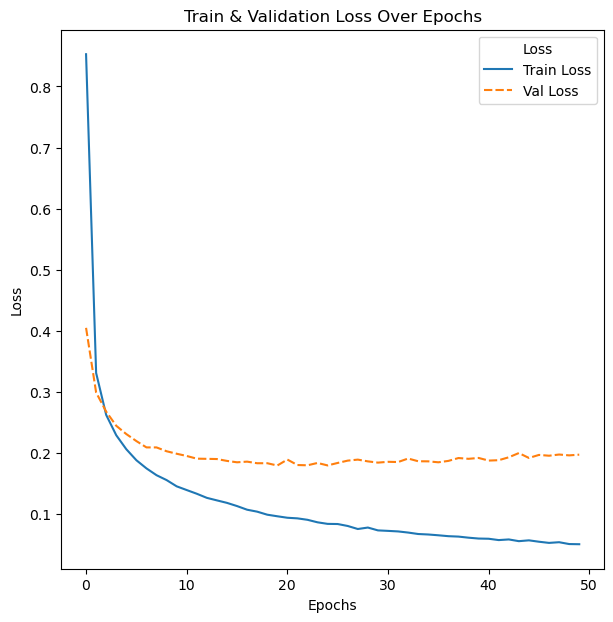

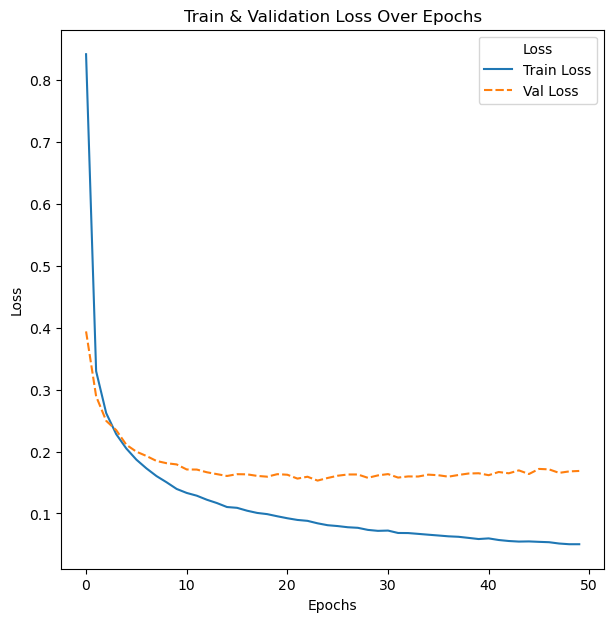

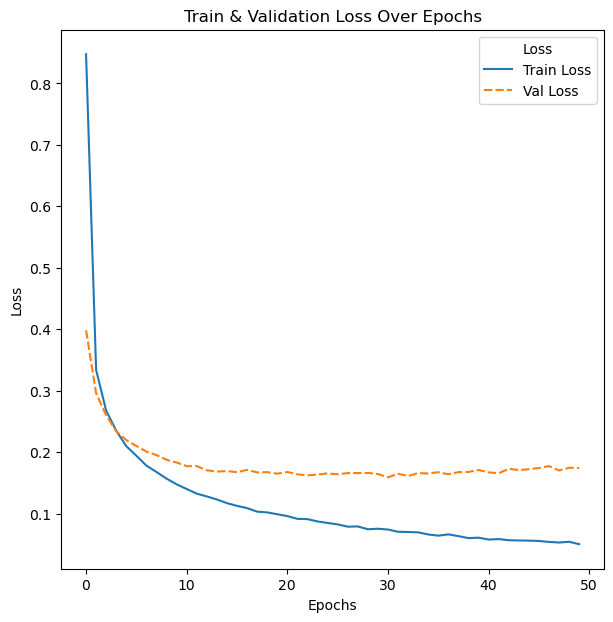

In [16]:
cross_valid(nml_train_X, train_y, nml_test_X)

With dropout of 15%, both this model's train and test accuracy are 1% lower than the 1d model. The 2a model's average train accuracy is around 98% and test accuracy is around 95%. On the other hand, the 1d model's average train accuracy is around 99% and test accuracy is around 96%. This dropoff in accuracy is expected as we have made it harder for the 2a model to fit to the train dataset by setting 15% of the hidden units to 0 during the training process. As for the bias-variance curves, both the training loss and validation loss curve for this model appear slightly higher than the model in 1d.

## 2b: No dropout, but L2 Regularization

In [17]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.lys = nn.ModuleList([nn.Linear(1024, 50),
                                  nn.Linear(50,10),])
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.lys[0](x)
        x = self.activation(x)
        x = self.lys[1](x)
        return x

  2%|▉                                           | 1/50 [00:01<01:03,  1.30s/it]

Epoch 1/50 - Loss: 0.785 - Acc: 0.832
              Val_loss: 0.362 - Val_acc: 0.906


 22%|█████████▍                                 | 11/50 [00:14<00:50,  1.28s/it]

Epoch 11/50 - Loss: 0.117 - Acc: 0.973
              Val_loss: 0.142 - Val_acc: 0.957


 42%|██████████████████                         | 21/50 [00:27<00:36,  1.27s/it]

Epoch 21/50 - Loss: 0.072 - Acc: 0.988
              Val_loss: 0.117 - Val_acc: 0.964


 62%|██████████████████████████▋                | 31/50 [00:39<00:24,  1.27s/it]

Epoch 31/50 - Loss: 0.055 - Acc: 0.994
              Val_loss: 0.113 - Val_acc: 0.966


 82%|███████████████████████████████████▎       | 41/50 [00:55<00:14,  1.61s/it]

Epoch 41/50 - Loss: 0.047 - Acc: 0.997
              Val_loss: 0.110 - Val_acc: 0.967


func:'train'  took: 68.0510 sec
Final Train Accuracy:  0.9980749999999978
Final Validation Accuracy:  0.9672999978065491
Test Accuracy:  0.9685999751091003
Final Train Loss:  0.043862775564193754
Final Validation Loss:  0.11198405921459198


  2%|▉                                           | 1/50 [00:01<01:00,  1.23s/it]

Epoch 1/50 - Loss: 0.789 - Acc: 0.826
              Val_loss: 0.354 - Val_acc: 0.909


 22%|█████████▍                                 | 11/50 [00:14<00:53,  1.36s/it]

Epoch 11/50 - Loss: 0.116 - Acc: 0.973
              Val_loss: 0.133 - Val_acc: 0.960


 42%|██████████████████                         | 21/50 [00:27<00:36,  1.27s/it]

Epoch 21/50 - Loss: 0.073 - Acc: 0.988
              Val_loss: 0.113 - Val_acc: 0.965


 62%|██████████████████████████▋                | 31/50 [00:41<00:26,  1.42s/it]

Epoch 31/50 - Loss: 0.056 - Acc: 0.994
              Val_loss: 0.110 - Val_acc: 0.967


 82%|███████████████████████████████████▎       | 41/50 [00:54<00:11,  1.26s/it]

Epoch 41/50 - Loss: 0.048 - Acc: 0.998
              Val_loss: 0.113 - Val_acc: 0.967


func:'train'  took: 66.3920 sec
Final Train Accuracy:  0.9983249999999978
Final Validation Accuracy:  0.967199981212616
Test Accuracy:  0.9668999910354614
Final Train Loss:  0.04520106455087662
Final Validation Loss:  0.11286933720111847


  2%|▉                                           | 1/50 [00:01<01:02,  1.27s/it]

Epoch 1/50 - Loss: 0.790 - Acc: 0.832
              Val_loss: 0.363 - Val_acc: 0.908


 22%|█████████▍                                 | 11/50 [00:14<00:51,  1.31s/it]

Epoch 11/50 - Loss: 0.116 - Acc: 0.972
              Val_loss: 0.143 - Val_acc: 0.957


 42%|██████████████████                         | 21/50 [00:28<00:39,  1.37s/it]

Epoch 21/50 - Loss: 0.075 - Acc: 0.987
              Val_loss: 0.124 - Val_acc: 0.963


 62%|██████████████████████████▋                | 31/50 [00:41<00:24,  1.31s/it]

Epoch 31/50 - Loss: 0.057 - Acc: 0.994
              Val_loss: 0.120 - Val_acc: 0.965


 82%|███████████████████████████████████▎       | 41/50 [00:54<00:12,  1.37s/it]

Epoch 41/50 - Loss: 0.048 - Acc: 0.997
              Val_loss: 0.125 - Val_acc: 0.965


func:'train'  took: 67.8731 sec
Final Train Accuracy:  0.9980499999999981
Final Validation Accuracy:  0.965499997138977
Test Accuracy:  0.9682000279426575
Final Train Loss:  0.04523087352514271
Final Validation Loss:  0.1254320740699768


ArtNN(
  (lys): ModuleList(
    (0): Linear(in_features=1024, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (activation): Sigmoid()
)

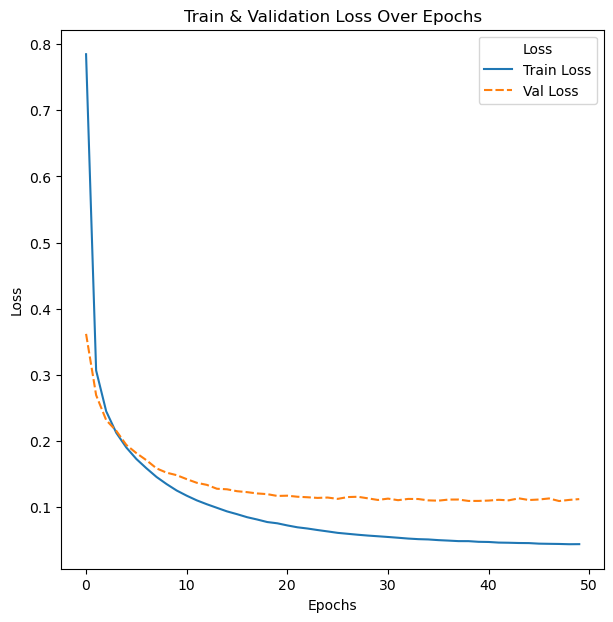

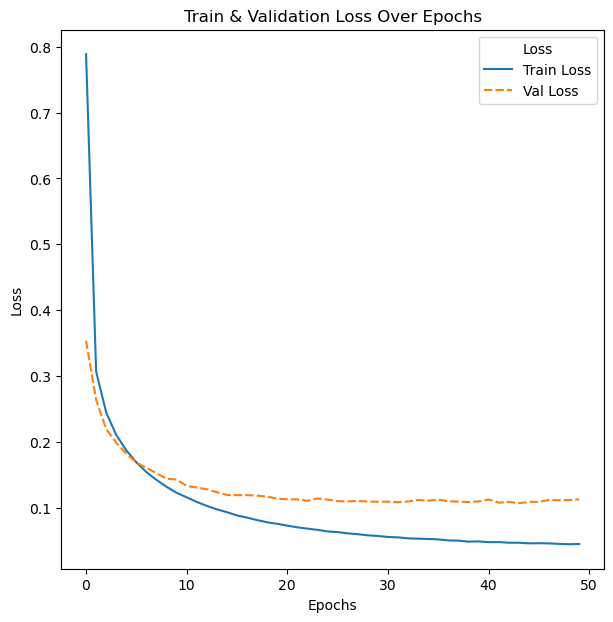

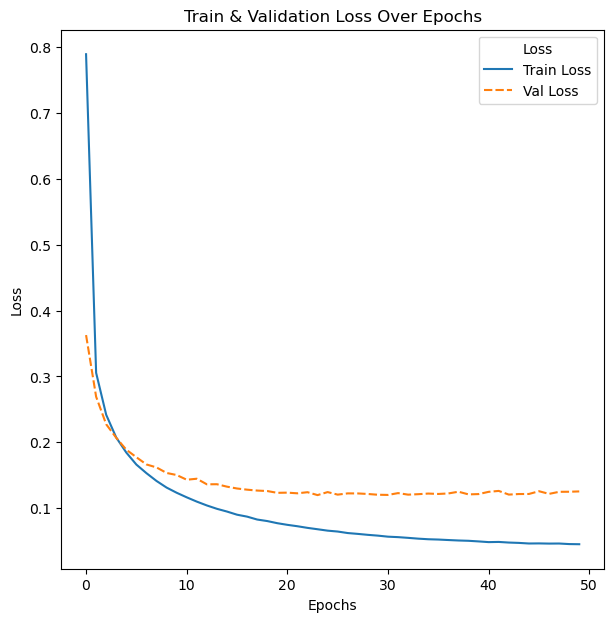

In [18]:
cross_valid(nml_train_X, train_y, nml_test_X, l2_ind= True)

With L2 regularization, this model's train and validation loss curves are tighter compared to the validation and train loss curves of the model in 1d. This model's average test accuracy is around 96%, which is 1% higher than the 1d model's average test accuracy. This model's average train accuracy is slightly lower the 1d model's average train accuracy. 

## 2c: PCA on Input Data

In [19]:
temp = lambda x: x.reshape(x.shape[0], -1)
atemp = temp(nml_train_X)

In [20]:
atemp.shape

(60000, 1024)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 0.99)
train_pca = pca.fit_transform(atemp)
train_pca.shape

(60000, 363)

In [22]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.lys = nn.ModuleList([nn.Linear(363, 50),
                                  nn.Linear(50,10),])
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.lys[0](x)
        x = self.activation(x)
        x = self.lys[1](x)
        return x

In [23]:
test_X_2d = temp(nml_test_X)

In [24]:
test_xpca = pca.transform(test_X_2d)
test_xpca.shape

(10000, 363)

  2%|▉                                           | 1/50 [00:01<00:54,  1.11s/it]

Epoch 1/50 - Loss: 1.078 - Acc: 0.791
              Val_loss: 0.425 - Val_acc: 0.900


 22%|█████████▍                                 | 11/50 [00:10<00:35,  1.11it/s]

Epoch 11/50 - Loss: 0.127 - Acc: 0.966
              Val_loss: 0.186 - Val_acc: 0.944


 42%|██████████████████                         | 21/50 [00:19<00:26,  1.11it/s]

Epoch 21/50 - Loss: 0.058 - Acc: 0.988
              Val_loss: 0.164 - Val_acc: 0.951


 62%|██████████████████████████▋                | 31/50 [00:28<00:17,  1.09it/s]

Epoch 31/50 - Loss: 0.025 - Acc: 0.997
              Val_loss: 0.170 - Val_acc: 0.951


 82%|███████████████████████████████████▎       | 41/50 [00:37<00:08,  1.09it/s]

Epoch 41/50 - Loss: 0.009 - Acc: 1.000
              Val_loss: 0.187 - Val_acc: 0.951


func:'train'  took: 46.0727 sec
Final Train Accuracy:  0.999924999999996
Final Validation Accuracy:  0.9501000046730042
Test Accuracy:  0.9564999938011169
Final Train Loss:  0.003903529735654593
Final Validation Loss:  0.20662075281143188


  2%|▉                                           | 1/50 [00:00<00:44,  1.11it/s]

Epoch 1/50 - Loss: 1.113 - Acc: 0.797
              Val_loss: 0.442 - Val_acc: 0.898


 22%|█████████▍                                 | 11/50 [00:10<00:35,  1.10it/s]

Epoch 11/50 - Loss: 0.127 - Acc: 0.966
              Val_loss: 0.192 - Val_acc: 0.943


 42%|██████████████████                         | 21/50 [00:19<00:26,  1.10it/s]

Epoch 21/50 - Loss: 0.058 - Acc: 0.987
              Val_loss: 0.171 - Val_acc: 0.951


 62%|██████████████████████████▋                | 31/50 [00:28<00:17,  1.07it/s]

Epoch 31/50 - Loss: 0.024 - Acc: 0.997
              Val_loss: 0.180 - Val_acc: 0.951


 82%|███████████████████████████████████▎       | 41/50 [00:38<00:09,  1.03s/it]

Epoch 41/50 - Loss: 0.009 - Acc: 1.000
              Val_loss: 0.199 - Val_acc: 0.950


func:'train'  took: 47.4425 sec
Final Train Accuracy:  0.9999749999999958
Final Validation Accuracy:  0.9503499865531921
Test Accuracy:  0.9549000263214111
Final Train Loss:  0.003732926601171492
Final Validation Loss:  0.22151440382003784


  2%|▉                                           | 1/50 [00:00<00:41,  1.17it/s]

Epoch 1/50 - Loss: 1.101 - Acc: 0.795
              Val_loss: 0.431 - Val_acc: 0.900


 22%|█████████▍                                 | 11/50 [00:10<00:37,  1.04it/s]

Epoch 11/50 - Loss: 0.129 - Acc: 0.964
              Val_loss: 0.185 - Val_acc: 0.947


 42%|██████████████████                         | 21/50 [00:23<00:35,  1.21s/it]

Epoch 21/50 - Loss: 0.061 - Acc: 0.987
              Val_loss: 0.162 - Val_acc: 0.952


 62%|██████████████████████████▋                | 31/50 [00:33<00:20,  1.07s/it]

Epoch 31/50 - Loss: 0.026 - Acc: 0.997
              Val_loss: 0.167 - Val_acc: 0.952


 82%|███████████████████████████████████▎       | 41/50 [00:42<00:08,  1.08it/s]

Epoch 41/50 - Loss: 0.010 - Acc: 1.000
              Val_loss: 0.182 - Val_acc: 0.953


func:'train'  took: 51.6975 sec
Final Train Accuracy:  0.9999999999999958
Final Validation Accuracy:  0.9536499977111816
Test Accuracy:  0.9563000202178955
Final Train Loss:  0.003823251334950329
Final Validation Loss:  0.2022329866886139


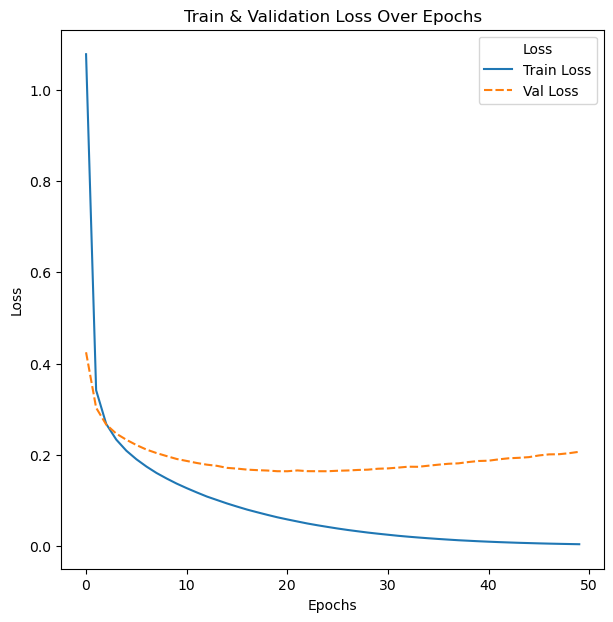

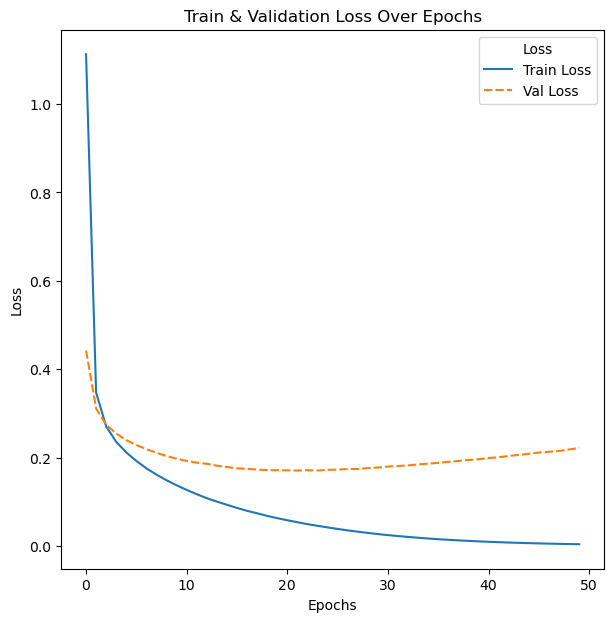

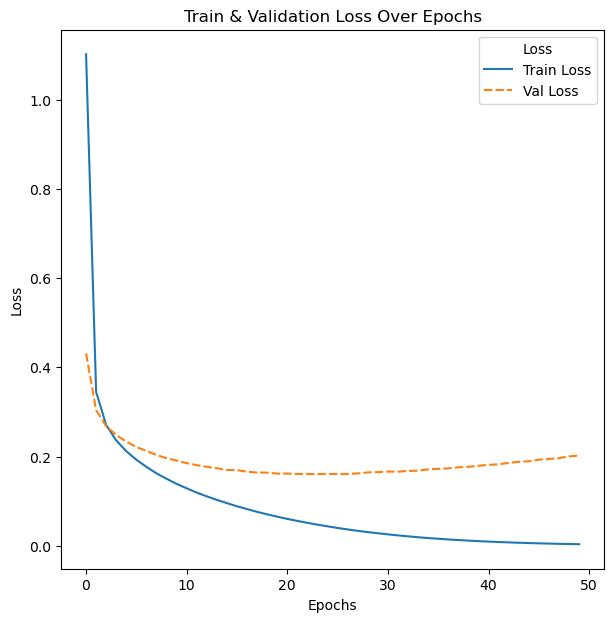

In [25]:
tuned_model = cross_valid(train_pca, train_y, test_xpca)

The number of parameters or features dropped from 1024 to 363 with the use of PCA, which has created a new, smaller set of features from the original dataset, but retains 99% of the variance of the original dataset. The bias-variance curves also look really similar for this model using the pca-transformed data and the 1d model using the entire dataset as is. 

## 2d: PCA with L2 Regularization

  2%|▉                                           | 1/50 [00:00<00:41,  1.17it/s]

Epoch 1/50 - Loss: 1.102 - Acc: 0.789
              Val_loss: 0.422 - Val_acc: 0.902


 22%|█████████▍                                 | 11/50 [00:13<00:51,  1.32s/it]

Epoch 11/50 - Loss: 0.146 - Acc: 0.962
              Val_loss: 0.175 - Val_acc: 0.948


 42%|██████████████████                         | 21/50 [00:23<00:30,  1.06s/it]

Epoch 21/50 - Loss: 0.087 - Acc: 0.985
              Val_loss: 0.144 - Val_acc: 0.957


 62%|██████████████████████████▋                | 31/50 [00:35<00:20,  1.10s/it]

Epoch 31/50 - Loss: 0.064 - Acc: 0.994
              Val_loss: 0.136 - Val_acc: 0.960


 82%|███████████████████████████████████▎       | 41/50 [00:45<00:09,  1.04s/it]

Epoch 41/50 - Loss: 0.053 - Acc: 0.998
              Val_loss: 0.134 - Val_acc: 0.961


func:'train'  took: 55.0524 sec
Final Train Accuracy:  0.9987749999999973
Final Validation Accuracy:  0.9621999859809875
Test Accuracy:  0.9624000191688538
Final Train Loss:  0.04813951492309571
Final Validation Loss:  0.13570035994052887


  2%|▉                                           | 1/50 [00:01<00:50,  1.02s/it]

Epoch 1/50 - Loss: 1.093 - Acc: 0.803
              Val_loss: 0.447 - Val_acc: 0.895


 22%|█████████▍                                 | 11/50 [00:11<00:40,  1.04s/it]

Epoch 11/50 - Loss: 0.144 - Acc: 0.964
              Val_loss: 0.192 - Val_acc: 0.942


 42%|██████████████████                         | 21/50 [00:21<00:30,  1.06s/it]

Epoch 21/50 - Loss: 0.089 - Acc: 0.984
              Val_loss: 0.157 - Val_acc: 0.954


 62%|██████████████████████████▋                | 31/50 [00:32<00:23,  1.22s/it]

Epoch 31/50 - Loss: 0.064 - Acc: 0.994
              Val_loss: 0.146 - Val_acc: 0.957


 82%|███████████████████████████████████▎       | 41/50 [00:44<00:10,  1.20s/it]

Epoch 41/50 - Loss: 0.053 - Acc: 0.998
              Val_loss: 0.144 - Val_acc: 0.958


func:'train'  took: 54.8725 sec
Final Train Accuracy:  0.9991249999999974
Final Validation Accuracy:  0.9605000019073486
Test Accuracy:  0.9610000252723694
Final Train Loss:  0.04803998702168465
Final Validation Loss:  0.14191575348377228


  2%|▉                                           | 1/50 [00:00<00:46,  1.06it/s]

Epoch 1/50 - Loss: 1.096 - Acc: 0.801
              Val_loss: 0.429 - Val_acc: 0.897


 22%|█████████▍                                 | 11/50 [00:12<00:46,  1.18s/it]

Epoch 11/50 - Loss: 0.144 - Acc: 0.964
              Val_loss: 0.183 - Val_acc: 0.945


 42%|██████████████████                         | 21/50 [00:25<00:35,  1.23s/it]

Epoch 21/50 - Loss: 0.089 - Acc: 0.984
              Val_loss: 0.151 - Val_acc: 0.955


 62%|██████████████████████████▋                | 31/50 [00:36<00:20,  1.06s/it]

Epoch 31/50 - Loss: 0.064 - Acc: 0.993
              Val_loss: 0.141 - Val_acc: 0.959


 82%|███████████████████████████████████▎       | 41/50 [00:47<00:11,  1.22s/it]

Epoch 41/50 - Loss: 0.053 - Acc: 0.997
              Val_loss: 0.138 - Val_acc: 0.960


func:'train'  took: 57.7151 sec
Final Train Accuracy:  0.9987249999999972
Final Validation Accuracy:  0.9600499868392944
Test Accuracy:  0.9643999934196472
Final Train Loss:  0.04809751330614088
Final Validation Loss:  0.13800404965877533


ArtNN(
  (lys): ModuleList(
    (0): Linear(in_features=363, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (activation): Sigmoid()
)

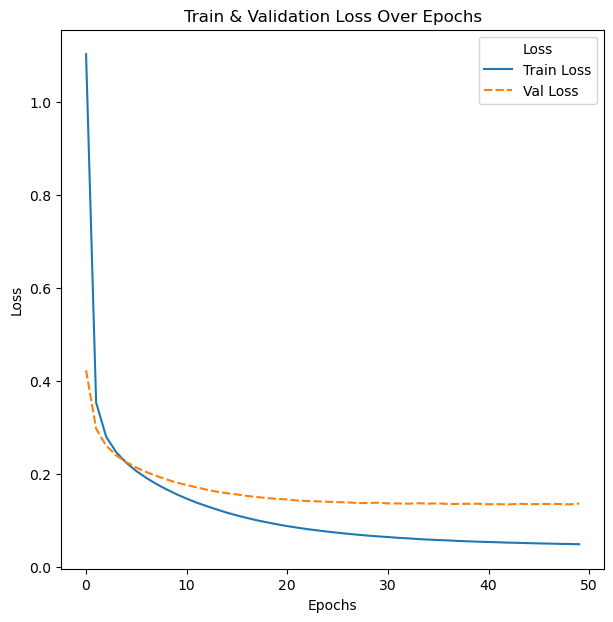

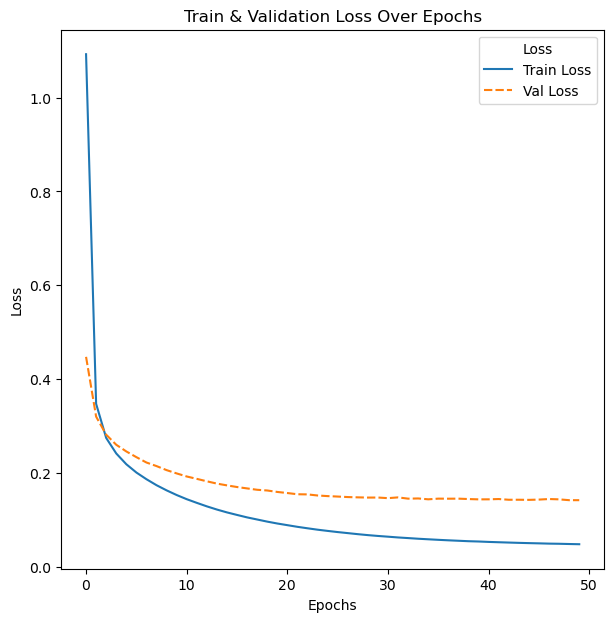

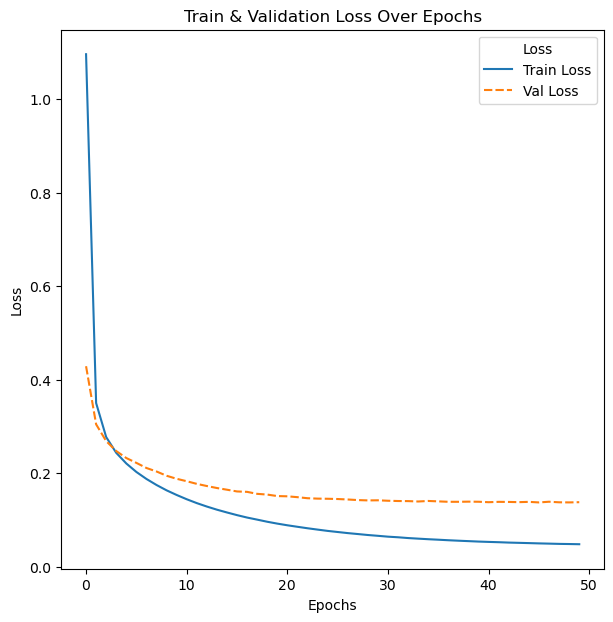

In [27]:
cross_valid(train_pca, train_y, test_xpca, l2_ind= True)

Training accuracy is around the same, but the training time is shorter by around 13 seconds. Thus, essentially, I am getting the same training results with a significant time dropoff, so the addition of PCA is great. 